In [2]:
%matplotlib inline
import time, sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

In [45]:
sac_data=pd.read_csv('SampleData_robotEye.csv',header=0)
sac_data.iloc[:,2]=sac_data.iloc[:,2]*(512/4.75)
sac_data.iloc[:,3]=sac_data.iloc[:,3]*(512/4.75)

In [46]:
sac_data

Unnamed: 0       0          1          2
0              0     1.0  25.000000  22.113827
1              1     2.0  25.000000  22.593616
2              2     3.0  25.000000  21.722010
3              3     4.0  25.000000  21.780389
4              4     5.0  25.000000  22.595010
...          ...     ...        ...        ...
9985        9985  9986.0  64.144737  21.683503
9986        9986  9987.0  66.118421  21.762043
9987        9987  9988.0  66.118421  22.234793
9988        9988  9989.0  65.789474  22.600025
9989        9989  9990.0  65.789474  22.333861

[9990 rows x 4 columns]

Welcome to the online saccade detection demo!


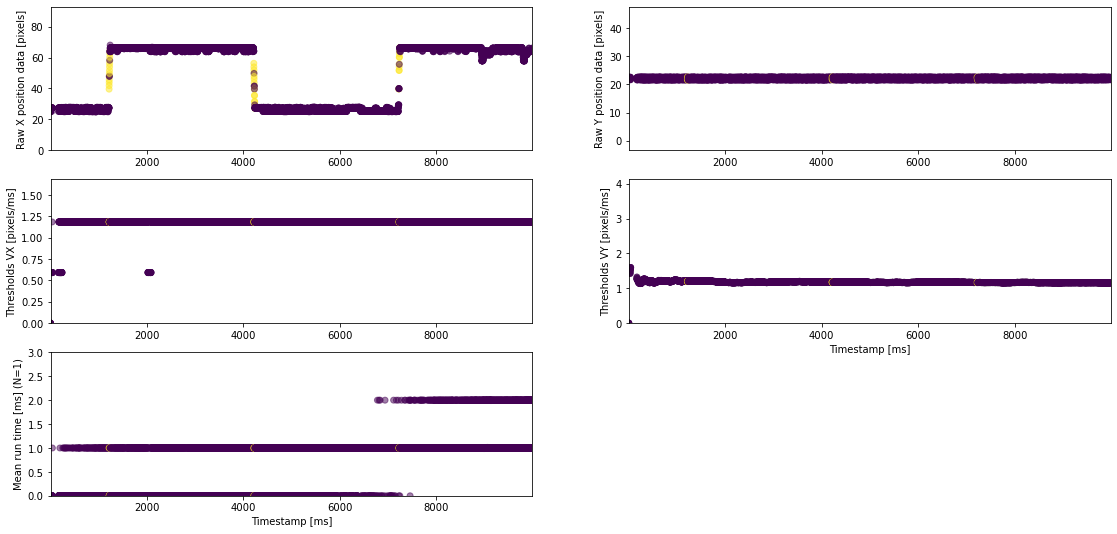

0.0
2.9976367950439453
Wall time: 11 s


In [47]:
%%time
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

How to run the saccade detection algorithm written in C from Python as a python module. 

# HOW TO COMPILE ?
ROUTE 1 (via .o)
1. create the C object:
    gcc -c -fPIC detect_saccade_pure_C_ONSET.c -o detect_saccade.o
2. create the shared object:
    gcc detect_saccade.o -shared -o detect_saccade.so
ROUTE 2 (directly to .so)
1. create the shared object directly:
    gcc -shared -o detect_saccade.so -fPIC detect_saccade_pure_C_ONSET.c 

# useful sources for using ctypes: 
    http://doc.sagemath.org/html/en/thematic_tutorials/numerical_sage/ctypes.html
    https://docs.python.org/2/library/ctypes.html
    https://www.csestack.org/calling-c-functions-from-python/

Created on Thu May 16 11:29:17 2019

@author: richard schweitzer
"""

import os
import ctypes
import numpy as np
import time

### this is the class for the returned structure of the detection algorithm
class detection_results(ctypes.Structure):
    _fields_ = [('sac_detected', ctypes.c_double),
                ('sac_t', ctypes.c_double), 
                ('sac_vx', ctypes.c_double), 
                ('sac_vy', ctypes.c_double), 
                ('threshold_vx', ctypes.c_double), 
                ('threshold_vy', ctypes.c_double), 
                ('sac_t_onset', ctypes.c_double) ]


### this is the detection module
class online_sac_detect:
    
    def __init__(self, lib_name='detect_saccade.so', lib_path=''):
        print('Loading online saccade detection Python module ' + __name__ + ' (by Richard Schweitzer)')
        # load the C file
        if lib_path=='':
            lib_path = os.path.dirname(os.path.realpath(__file__)) + '/'
        self.lib_name = lib_name
        self.lib_path = lib_path
        print('Now CDLL-loading: ' + self.lib_path + self.lib_name)
        self.lib_sac_detect = ctypes.CDLL(self.lib_path + self.lib_name)
        # define the results type of the detect function 
        self.lib_sac_detect.run_detection.restype = detection_results 
        # not preallocate
        self.x = np.array([])
        self.y = np.array([])
        self.t = np.array([])
        self.current_n_samples = 0
        # set the default parameters:
        print('Loading default parameters... Call set_parameters() to change!')
        self.set_parameters(print_parameters=False)
        print('Ready to go! Now you only have to import some data via add_data()!')

    def set_parameters(self, thres_fac=10, above_thres_needed=3, 
                       restrict_dir_min=0, restrict_dir_max=0,
                       samp_rate=0, anchor_vel_thres=10, print_results=0, 
                       print_parameters=False):
        self.thres_fac = thres_fac
        self.above_thres_needed = above_thres_needed
        self.restrict_dir_min = restrict_dir_min
        self.restrict_dir_max = restrict_dir_max
        self.samp_rate = samp_rate
        self.anchor_vel_thres = anchor_vel_thres
        self.print_results = print_results
        if print_parameters:
            print('Sac detect parameters are now: thres_fac=' + str(self.thres_fac) +  
                  ' above_thres_needed=' + str(self.above_thres_needed) + 
                  ' restrict_dir min max =' + str([self.restrict_dir_min, self.restrict_dir_max]) + 
                  ' samp_rate=' + str(self.samp_rate) + 
                  ' anchor_vel_thres=' + str(self.anchor_vel_thres) + 
                  ' print_results=' + str(self.print_results) )
    
    def get_parameters(self):
        return(self.thres_fac, self.above_thres_needed, 
            self.restrict_dir_min, self.restrict_dir_max, 
            self.samp_rate, self.anchor_vel_thres, self.print_results)
    
    def reset_data(self):
        self.x = np.array([], dtype=float)
        self.y = np.array([], dtype=float)
        self.t = np.array([], dtype=float)
        self.current_n_samples = 0
    
    def add_data(self, x, y, t):
        self.x = np.append(self.x, np.array(x, dtype=float))
        self.y = np.append(self.y, np.array(y, dtype=float))
        self.t = np.append(self.t, np.array(t, dtype=float))
        assert(np.size(x)==np.size(y))
        assert(np.size(x)==np.size(t))
        self.current_n_samples = len(self.x)

    def return_data(self):
        return(self.x, self.y, self.t)
    
    def run_detection(self):
        x_p = self.x.ctypes.data_as(ctypes.c_void_p)
        y_p = self.y.ctypes.data_as(ctypes.c_void_p)
        t_p = self.t.ctypes.data_as(ctypes.c_void_p)
        if np.size(self.x) < (2*self.above_thres_needed):
            print('WARNING: You run the detection without having more than twice the amount of samples needed!')
        t0 = time.time()
        res_here = self.lib_sac_detect.run_detection( x_p, y_p, t_p, 
                                 self.thres_fac, self.above_thres_needed, 
                                 self.restrict_dir_min, self.restrict_dir_max,
                                 self.samp_rate, self.anchor_vel_thres, self.print_results, 
                                 self.current_n_samples ) 
        run_time_here = (time.time() - t0) * 1000 # in ms
        return(res_here, run_time_here)

        

### DEMO 
if __name__ == '__main__': 
    
    import matplotlib.pyplot as plt
    
    print('Welcome to the online saccade detection demo!')
    
    ## 1. set the parameters of interest
    # simulation options
    start_sample = 10 # this is the sample where we start collecting
    wait_after_each_sample = 0.0005 # in seconds
    timing_iterations =1# how many iterations for the timing? set this to any integer value. 
    # saccade detection options
    thres_fac = int(18)# threshold factor, or lambda
    above_thres_needed = int(3) # how many samples above threshold do we need?
    restrict_dir_min = int(0) # direction restriction.
    restrict_dir_max = int(0)
    samp_rate_now = int(1000) #resampling frequency
    anchor_vel_thres = thres_fac
    print_results = 0 # set to 0, if you don't want any feedback from stdout
    # plotting options
    thres_scale_pm = 0.5
    pixel_scale_pm = 25
    run_scale_pm = 0.01
    plot_alpha = 0.5
    plot_x_inches = 19
    plot_y_inches = 9
    
    ## 2. read the saccade data (one eye, horizontal rightward saccade, collected at 500 Hz).
    # columns: time relative to saccade onset, time raw, x position raw, y position raw
#    sac_data = np.genfromtxt('./example_saccade.csv', delimiter=',')
#     sac_data=np.genfromtxt('./eyepos_rubbereye.csv', delimiter=',')
    num_samples=len(sac_data)
    x_sac = sac_data.iloc[0:num_samples,2]
    y_sac = sac_data.iloc[0:num_samples,3]
    t_sac = sac_data.iloc[0:num_samples,1] # should be on millisecond scale
#     t_sac_onset = float(sac_data[np.where(sac_data[:,3]==0),1])
    # pre-allocate
    thresholds_vx = np.zeros(len(x_sac))
    thresholds_vy = np.zeros(len(x_sac))
    all_run_times = np.zeros(len(x_sac))
    all_convert_times = np.zeros(len(x_sac)-start_sample)
    detected = np.zeros(len(x_sac))
    
    ## 3. import the module and set parameters
    import online_sac_detect_module
    detect_this = online_sac_detect_module.online_sac_detect()
    detect_this.set_parameters(thres_fac, above_thres_needed, 
                               restrict_dir_min, restrict_dir_max, 
                               samp_rate_now, anchor_vel_thres, print_results)
    detect_this.return_data() # returns current data (should be empty after loading)
    detect_this.get_parameters() # returns current parameters
    
    ### 4. loop through samples, display results, get timing
    do_plot = True
    # the loop
    for sample_i in range(start_sample, len(x_sac)):
        # simulate the retrieval of samples up to a certain point
        t0 = time.time()
        if sample_i == start_sample: # load the data up to the start sample
            detect_this.add_data(x_sac[range(1, sample_i)], 
                                  y_sac[range(1, sample_i)], 
                                  t_sac[range(1, sample_i)])
        else: # add each new sample coming in... 
            detect_this.add_data(x_sac[sample_i], 
                                 y_sac[sample_i], 
                                 t_sac[sample_i])
        all_convert_times[sample_i-start_sample] = (time.time() - t0) * 1000 # in ms
        
#        # for debugging and to see whether warning messages work
#        detect_this.set_parameters(above_thres_needed = 20, print_results = False)
#        detect_this.set_parameters(above_thres_needed = 3, print_results = True, samp_rate=1000)

        # run the detection and time it...
#        print('Run detection with n=' + str(detect_this.current_n_samples) + ' samples...')
        run_times = np.ones(timing_iterations)
        for run_i in range(timing_iterations):
            try:
                res_here, run_time_here = detect_this.run_detection() 
            except OSError:
                if sample_i==1:
                    print('OSError!')
            run_times[run_i] = run_time_here
        mean_run_time = np.mean(run_times)
        # save data
        all_run_times[sample_i] = mean_run_time
        thresholds_vx[sample_i] = res_here.threshold_vx
        thresholds_vy[sample_i] = res_here.threshold_vy
        detected[sample_i] = res_here.sac_detected
        ## display the results in a interactive plot
        if do_plot and sample_i==len(x_sac)-1:
            current_index = range(1, sample_i)
            x_here = x_sac[current_index]
            y_here = y_sac[current_index]
            t_here = t_sac[current_index]
            # figure
            plt.clf()
            fig = plt.figure(1, figsize=(2, 3))
            fig.set_size_inches(plot_x_inches, plot_y_inches, forward=True)
            # the raw data
            plt.subplot(321)  # X 
            plt.axis([t_sac[start_sample], max(t_sac), 
                      min(x_sac)-pixel_scale_pm, max(x_sac)+pixel_scale_pm])
            plt.scatter(t_here, x_here, c=detected[current_index], 
                        alpha = plot_alpha)
#             plt.axvline(x=t_sac_onset, linestyle='--') # saccade onset reference line
            plt.ylabel('Raw X position data [pixels]')
            plt.subplot(322) # Y
            plt.axis([t_sac[start_sample], max(t_sac), 
                      min(y_sac)-pixel_scale_pm, max(y_sac)+pixel_scale_pm])
            plt.scatter(t_here, y_here, c=detected[current_index], 
                        alpha = plot_alpha)
#             plt.axvline(x=t_sac_onset, linestyle='--') # saccade onset reference line
            plt.ylabel('Raw Y position data [pixels]')
            # the thresholds
            plt.subplot(323) 
            plt.axis([t_sac[start_sample], max(t_sac), 
                      min(thresholds_vx[current_index]), 
                      max(thresholds_vx[current_index])+thres_scale_pm])
            plt.scatter(t_here, thresholds_vx[current_index], c=detected[current_index], 
                        alpha = plot_alpha)
#             plt.axvline(x=t_sac_onset, linestyle='--') # saccade onset reference line
            plt.ylabel('Thresholds VX [pixels/ms]')
            plt.subplot(324) 
            plt.axis([t_sac[start_sample], max(t_sac), 
                      min(thresholds_vy[current_index]), 
                      max(thresholds_vy[current_index])+thres_scale_pm])
            plt.scatter(t_here, thresholds_vy[current_index], c=detected[current_index], 
                        alpha = plot_alpha)
#             plt.axvline(x=t_sac_onset, linestyle='--') # saccade onset reference line
            plt.ylabel('Thresholds VY [pixels/ms]')
            plt.xlabel('Timestamp [ms]')
            # the run time
            plt.subplot(325) 
            plt.axis([t_sac[start_sample], max(t_sac), 
                      min(all_run_times[current_index]), max(all_run_times[current_index])+run_scale_pm])
            plt.scatter(t_here, all_run_times[current_index], c=detected[current_index], 
                        alpha = plot_alpha)
#             plt.axvline(x=t_sac_onset, linestyle='--') # saccade onset reference line
            plt.ylabel('Mean run time [ms] (N=' + str(timing_iterations) + ')')
            plt.xlabel('Timestamp [ms]')
            # wait
            plt.pause(wait_after_each_sample)
                
    # done!
    if do_plot:
        plt.show()
  
    # final running times:
    x, y, t = detect_this.return_data()
    print(np.median(all_convert_times))
    print(np.max(all_run_times))

<AxesSubplot:>

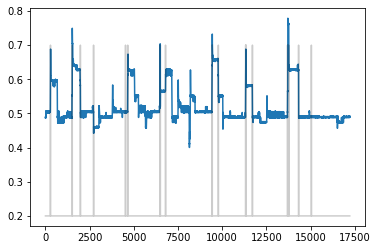

In [25]:
sac_data['xpos'].plot()
sac_data['sac_rescale']=np.where(sac_data['sac_detected']==1,0.7,0.2)
sac_data['sac_rescale'].plot(alpha=0.2,label='Saccade detected',color='k')

In [11]:
sac_data

time      xpos      ypos  sac_detected  stimTime
0       96.6826  0.505371  0.224884           0.0       0.0
1       97.6644  0.505371  0.208271           0.0       0.0
2       98.4132  0.505371  0.205930           0.0       0.0
3       99.1525  0.505371  0.212678           0.0       0.0
4       99.9061  0.507812  0.248850           0.0       0.0
...         ...       ...       ...           ...       ...
6870  6127.5460  0.642090  0.235173           0.0       0.0
6871  6128.3988  0.639648  0.244762           0.0       0.0
6872  6129.2227  0.642090  0.223158           0.0       0.0
6873  6130.0752  0.642090  0.218926           0.0       0.0
6874  6130.9622  0.639648  0.242536           0.0       0.0

[6875 rows x 5 columns]